# Taipei 
## 1. Data Cleaning and Translation

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg
import geopandas.tools
import folium
from folium import plugins
from IPython.display import Image

In [2]:
#Image(filename='taipei-metro-map.jpg') 

In [3]:
ltt = pd.read_csv("taipei-metro-link-travel-time.csv")
ltt.head()

,line,stationA,stationB,traveltime,id,stoptime_A
0,淡水-象山,捷運淡水站,捷運紅樹林站,175,1,0
1,淡水-象山,捷運紅樹林站,捷運竹圍站,136,2,25
2,淡水-象山,捷運竹圍站,捷運關渡站,145,3,25
3,淡水-象山,捷運關渡站,捷運忠義站,78,4,25
4,淡水-象山,捷運忠義站,捷運復興崗站,109,5,25


In [4]:
# remove redundant characters
ltt["stationA"] = ltt["stationA"].str.replace("捷運", "")
ltt["stationA"] = ltt["stationA"].str.replace("站", "")
ltt["stationB"] = ltt["stationB"].str.replace("捷運", "")
ltt["stationB"] = ltt["stationB"].str.replace("站", "")
ltt.head()

,line,stationA,stationB,traveltime,id,stoptime_A
0,淡水-象山,淡水,紅樹林,175,1,0
1,淡水-象山,紅樹林,竹圍,136,2,25
2,淡水-象山,竹圍,關渡,145,3,25
3,淡水-象山,關渡,忠義,78,4,25
4,淡水-象山,忠義,復興崗,109,5,25


In [5]:
# create a dictionary for line name mapping
### s: short-turn route
### f: feeder route
### O1, O2: branch routes of Orange line
line_dict = {'淡水-象山':'R',
             '北投-大安':'Rs',
             '松山-新店':'G',
             '松山-台電大樓':'Gs',
             '七張-小碧潭':'Gf',
             '北投-新北投':'Rf',
             '南港展覽館-頂埔':'BL',
             '南港展覽館-亞東醫院':'BLs',
             '動物園-南港展覽館':'BR',
             '南勢角-蘆洲':'O2',
             '南勢角-迴龍':'O1'}

In [6]:
# create a dictionary for station name mapping
name = pd.read_csv("taipei-metro-station-id.csv")

station_dict = dict(zip(name['name_ch'], name['station_id']))

In [7]:
# map line and stations to ids
ltt.replace({"line":line_dict,
             "stationA":station_dict,
             "stationB":station_dict}, inplace=True)
ltt.head()

,line,stationA,stationB,traveltime,id,stoptime_A
0,R,R28,R27,175,1,0
1,R,R27,R26,136,2,25
2,R,R26,R25,145,3,25
3,R,R25,R24,78,4,25
4,R,R24,R23,109,5,25


In [8]:
#save to new file
ltt.to_csv("ltt.csv")

Note: some discrepancies in station names, these were changed manually and updated as 'tpe_ltt_updated.csv'. 

## 2. Generate subnodes

In [2]:
import json

with open("station_locations.json") as json_file:
    json_data = json.load(json_file)
    

In [3]:
json_data['features'][0]['properties']['NAME']

u'\u6de1\u6c34\u7ad9'

In [4]:
len(json_data['features'])

103

In [12]:
lat = []
for i in range(len(json_data['features'])):
    lat.append(json_data['features'][i]['geometry']['coordinates'][1])
lat = [float(i) for i in lat]

In [13]:
lon = []
for i in range(len(json_data['features'])):
    lon.append(json_data['features'][i]['geometry']['coordinates'][0])
lon = [float(i) for i in lon]

In [14]:
name = []
for i in range(len(json_data['features'])):
    name.append(json_data['features'][i]['properties']['NAME'])

In [15]:
stops = pd.DataFrame()
stops['name'] = name
stops['Latitude'] = lat
stops['Longitude'] = lon

In [16]:
stops.to_csv('stops_chineseNames.csv',encoding="utf-8")

In [17]:
#rename stops 
stops = pd.read_csv('stops_chineseNames.csv')

In [18]:
stops['name'] = stops['name'].str.replace("站", "")

In [19]:
# map line and stations to ids
stops.replace({"name":station_dict}, inplace=True)
stops.drop('Unnamed: 0', axis=1, inplace=True)

In [20]:
stops.to_csv('station_locations.csv')

Note: again some discrepancies in stations names, some stations with different names and missing stations. Manually edited and saved as 'master_nodes_updated.csv'

In [5]:
master = pd.read_csv('master_nodes_updated.csv')

In [6]:
master.head()

,name,lat,lon
0,R28,25.167993,121.445258
1,R27,25.154114,121.458954
2,R26,25.136949,121.459456
3,R25,25.125652,121.467081
4,R24,25.131125,121.473242


In [7]:
master.shape

(114, 3)

In [8]:
transfer = master[master['lat'].duplicated(keep=False)].reset_index(drop=True)

In [9]:
transfer.to_csv('transfer.csv')

In [10]:
#manually create subnodes for transfer stations
transfer_sub = pd.read_csv('transfer_updated.csv')
transfer_sub.drop('line', axis=1, inplace=True)

In [11]:
master['subnode_id'] = master['name'] + '_' + master['name']
subnodes = master.append(transfer_sub, ignore_index=True)
subnodes.head()

,name,lat,lon,subnode_id
0,R28,25.167993,121.445258,R28_R28
1,R27,25.154114,121.458954,R27_R27
2,R26,25.136949,121.459456,R26_R26
3,R25,25.125652,121.467081,R25_R25
4,R24,25.131125,121.473242,R24_R24


In [12]:
subnodes.shape

(138, 4)

In [13]:
print 'Sub Nodes Number:', len(subnodes)
print 'Master Nodes Number:', len(master)
print 'Unique Station Name:', len(set(master['name']))

Sub Nodes Number: 138
Master Nodes Number: 114
Unique Station Name: 114


## 3. Load OD data for February 2017
- rename station names 

In [14]:
df_0217 = pd.read_csv("TPE_OD_0217.csv", sep='\s+', index_col=0, skiprows=[1,6858432,6858434]).reset_index().drop([6858431])
df_0217['日期'] = pd.to_datetime(df_0217['日期'])
df_0217.tail()

/Users/rachellim/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,日期,時段,進站,出站,人次
6858426,2017-02-28,23,丹鳳,三民高中,0.0
6858427,2017-02-28,23,丹鳳,徐匯中學,0.0
6858428,2017-02-28,23,丹鳳,三和國中,0.0
6858429,2017-02-28,23,丹鳳,三重國小,0.0
6858430,2017-02-28,23,丹鳳,丹鳳,3.0


In [31]:
# map stations to ids
df_0217.replace({"進站":station_dict,
             "出站":station_dict}, inplace=True)
df_0217.replace('大橋頭站', 'O12', inplace=True)
df_0217.head()

,日期,時段,進站,出站,人次
0,2017-02-01,0,BR13,BR13,0.0
1,2017-02-01,0,BR13,BR12,0.0
2,2017-02-01,0,BR13,G16,0.0
3,2017-02-01,0,BR13,BL15,0.0
4,2017-02-01,0,BR13,R05,1.0


In [32]:
df_0217.shape

(6858431, 5)

In [33]:
df_0217.to_csv('OD_Feb17.csv')

After checking data, all stations have been renamed except '大橋頭站'. Replace with corresponding station name 'O12'

## 3. Preliminary Analysis
- make type 1 data from type 2
- generate heatmap for entry and exits 

In [15]:
feb = pd.read_csv('OD_Feb17.csv').drop('Unnamed: 0', axis=1)

In [16]:
feb.head()

,日期,時段,進站,出站,人次
0,2017-02-01,0,BR13,BR13,0.0
1,2017-02-01,0,BR13,BR12,0.0
2,2017-02-01,0,BR13,G16,0.0
3,2017-02-01,0,BR13,BL15,0.0
4,2017-02-01,0,BR13,R05,1.0


In [17]:
feb.columns = ['Date', 'Time', 'In', 'Out', 'Count']

In [18]:
daily_volume = feb.groupby('Date')['Count'].sum().reset_index()

In [19]:
daily_volume.head()

,Date,Count
0,2017-02-01,1563403.0
1,2017-02-02,1988661.0
2,2017-02-03,2158018.0
3,2017-02-04,1989778.0
4,2017-02-05,1708957.0


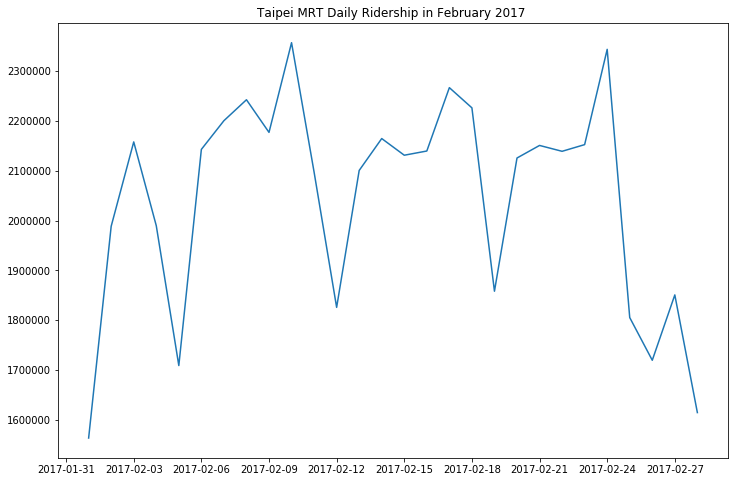

In [20]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
plt.figure(figsize=(12,8))
daily_volume['Date'] = pd.to_datetime(daily_volume['Date'], format= "%Y-%m-%d")
plt.plot(daily_volume['Date'], daily_volume['Count'])
plt.title('Taipei MRT Daily Ridership in February 2017 ', size=12)
plt.show()

#### Make Type 1 Data

In [29]:
#filter for one day
feb01 = feb.loc[feb['Date'] == '2017-02-01']
#group data into AM and PM peak for plotting
AMpeak = [5, 6, 7, 8, 9, 10]
PMpeak = [15, 16, 17, 18, 19]
feb01AMPeak = feb01.loc[feb01['Time'].isin(AMpeak)]
feb01PMPeak = feb01.loc[feb01['Time'].isin(PMpeak)]
print feb01AMPeak.shape
print feb01PMPeak.shape
#convert type 2 to type 1
feb01AMPeak_IN = feb01AMPeak.groupby(['In'])['Count'].sum().reset_index()
feb01PMPeak_IN = feb01PMPeak.groupby(['In'])['Count'].sum().reset_index()


(69984, 5)
(58320, 5)


In [30]:
feb01PMPeak_IN.head()

,In,Count
0,BL01,1853.0
1,BL02,3487.0
2,BL03,1661.0
3,BL04,4451.0
4,BL05,4135.0


In [31]:
#filter for one day
feb01 = feb.loc[feb['Date'] == '2017-02-01']
#group data into AM and PM peak for plotting
AMpeak = [5, 6, 7, 8, 9, 10]
PMpeak = [15, 16, 17, 18, 19]
feb01AMPeak = feb01.loc[feb01['Time'].isin(AMpeak)]
feb01PMPeak = feb01.loc[feb01['Time'].isin(PMpeak)]
#convert type 2 to type 1
feb01AMPeak_OUT = feb01AMPeak.groupby(['Out'])['Count'].sum().reset_index()
feb01PMPeak_OUT = feb01PMPeak.groupby(['Out'])['Count'].sum().reset_index()
feb01PMPeak_OUT.head()

,Out,Count
0,BL01,2210.0
1,BL02,3539.0
2,BL03,2363.0
3,BL04,7058.0
4,BL05,4680.0


In [32]:
#merge with spatial data
feb01AMPeak_geo_IN = feb01AMPeak_IN.merge(master, left_on='In', right_on='name').drop(['name', 'subnode_id'], axis=1)
feb01PMPeak_geo_IN = feb01PMPeak_IN.merge(master, left_on='In', right_on='name').drop(['name', 'subnode_id'], axis=1)

feb01AMPeak_geo_OUT = feb01AMPeak_OUT.merge(master, left_on='Out', right_on='name').drop(['name', 'subnode_id'], axis=1)
feb01PMPeak_geo_OUT = feb01PMPeak_OUT.merge(master, left_on='Out', right_on='name').drop(['name', 'subnode_id'], axis=1)

In [24]:
#lat, long for taipei city
m = folium.Map([24.96722082, 121.436827], zoom_start=11)
m

In [33]:
# extract lat, lon, and magnitude for the folium heatmap
latsAM = feb01AMPeak_geo_IN['lat']
lonsAM = feb01AMPeak_geo_IN['lon']
magAM = feb01AMPeak_geo_IN['Count']/float(feb01AMPeak_geo_IN['Count'].max())

# extract lat, lon, and magnitude for the folium heatmap
latsPM = feb01PMPeak_geo_OUT['lat']
lonsPM = feb01PMPeak_geo_OUT['lon']
magPM = feb01PMPeak_geo_OUT['Count']/float(feb01PMPeak_geo_OUT['Count'].max())


In [36]:
# plot heatmap for AM
# Using USGS style tile
url_base = 'http://server.arcgisonline.com/ArcGIS/rest/services/'
service = 'NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}'
tileset = url_base + service
max_amount = float(feb01AMPeak_geo_IN['Count'].max())

m = folium.Map(location=[24.96722082, 121.436827], zoom_start=11,\
                control_scale = True, tiles=tileset, attr='USGS style')

m.add_children(plugins.HeatMap(zip(latsAM, lonsAM, magAM), radius = 20))

/Users/rachellim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  # Remove the CWD from sys.path while we load stuff.


In [38]:
# plot heatmap for PM
# Using USGS style tile
url_base = 'http://server.arcgisonline.com/ArcGIS/rest/services/'
service = 'NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}'
tileset = url_base + service
max_amount = float(feb01PMPeak_geo_IN['Count'].max())

m = folium.Map(location=[24.96722082, 121.436827], zoom_start=11,\
                control_scale = True, tiles=tileset, attr='USGS style')

m.add_children(plugins.HeatMap(zip(latsPM, lonsPM, magPM), radius = 15))

/Users/rachellim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  # Remove the CWD from sys.path while we load stuff.


In [39]:
feb01AMPeak_geo_IN["geometry"] = feb01AMPeak_geo_IN.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
feb01PMPeak_geo_IN["geometry"] = feb01PMPeak_geo_IN.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)

feb01AMPeak_geo_OUT["geometry"] = feb01AMPeak_geo_OUT.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
feb01PMPeak_geo_OUT["geometry"] = feb01PMPeak_geo_OUT.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)

In [40]:
# Convert to a GeoDataFrame
crs = {'init': 'epsg:4326'}
feb01AMPeak_geo_IN = gpd.GeoDataFrame(feb01AMPeak_geo_IN, geometry="geometry", crs=crs)
feb01PMPeak_geo_IN = gpd.GeoDataFrame(feb01PMPeak_geo_IN, geometry="geometry", crs=crs)

feb01AMPeak_geo_OUT = gpd.GeoDataFrame(feb01AMPeak_geo_OUT, geometry="geometry", crs=crs)
feb01PMPeak_geo_OUT = gpd.GeoDataFrame(feb01PMPeak_geo_OUT, geometry="geometry", crs=crs)

In [41]:
import geopandas as gp
route = gp.GeoDataFrame.from_file(
    'routes/TpeMRTRoutes_TWD97.shp')
route.head()

,OBJECTID,LENGTH,RouteName,geometry
0,1.0,10078.770,淡水線,(LINESTRING (294734.7749419876 2784579.7576082...
1,2.0,2095.643,蘆洲線,LINESTRING (297459.4474940991 2776589.34191525...
2,7.0,4283.014,中和線,LINESTRING (302748.8380457393 2768839.46184240...
3,10.0,0.000,新店線,LINESTRING (304338.7060529941 2761408.83262833...
4,11.0,0.000,碧潭支線,LINESTRING (303449.7978839658 2762825.19631635...


In [42]:
route.to_crs(epsg=4326, inplace=True)
feb01AMPeak_geo_IN.to_crs(epsg=4326, inplace=True)
feb01PMPeak_geo_IN.to_crs(epsg=4326, inplace=True)

feb01AMPeak_geo_OUT.to_crs(epsg=4326, inplace=True)
feb01PMPeak_geo_OUT.to_crs(epsg=4326, inplace=True)
feb01AMPeak_geo_OUT.head()

,Out,Count,lat,lon,geometry
0,BL02,1494.0,24.967221,121.436827,POINT (121.4368273 24.96722082)
1,BL03,611.0,24.973226,121.444452,POINT (121.4444516 24.97322602)
2,BL04,1009.0,24.985548,121.448875,POINT (121.4488753 24.98554828)
3,BL05,1949.0,24.998589,121.452649,POINT (121.4526489 24.99858903)
4,BL06,1829.0,25.008935,121.459219,POINT (121.4592189 25.00893484)


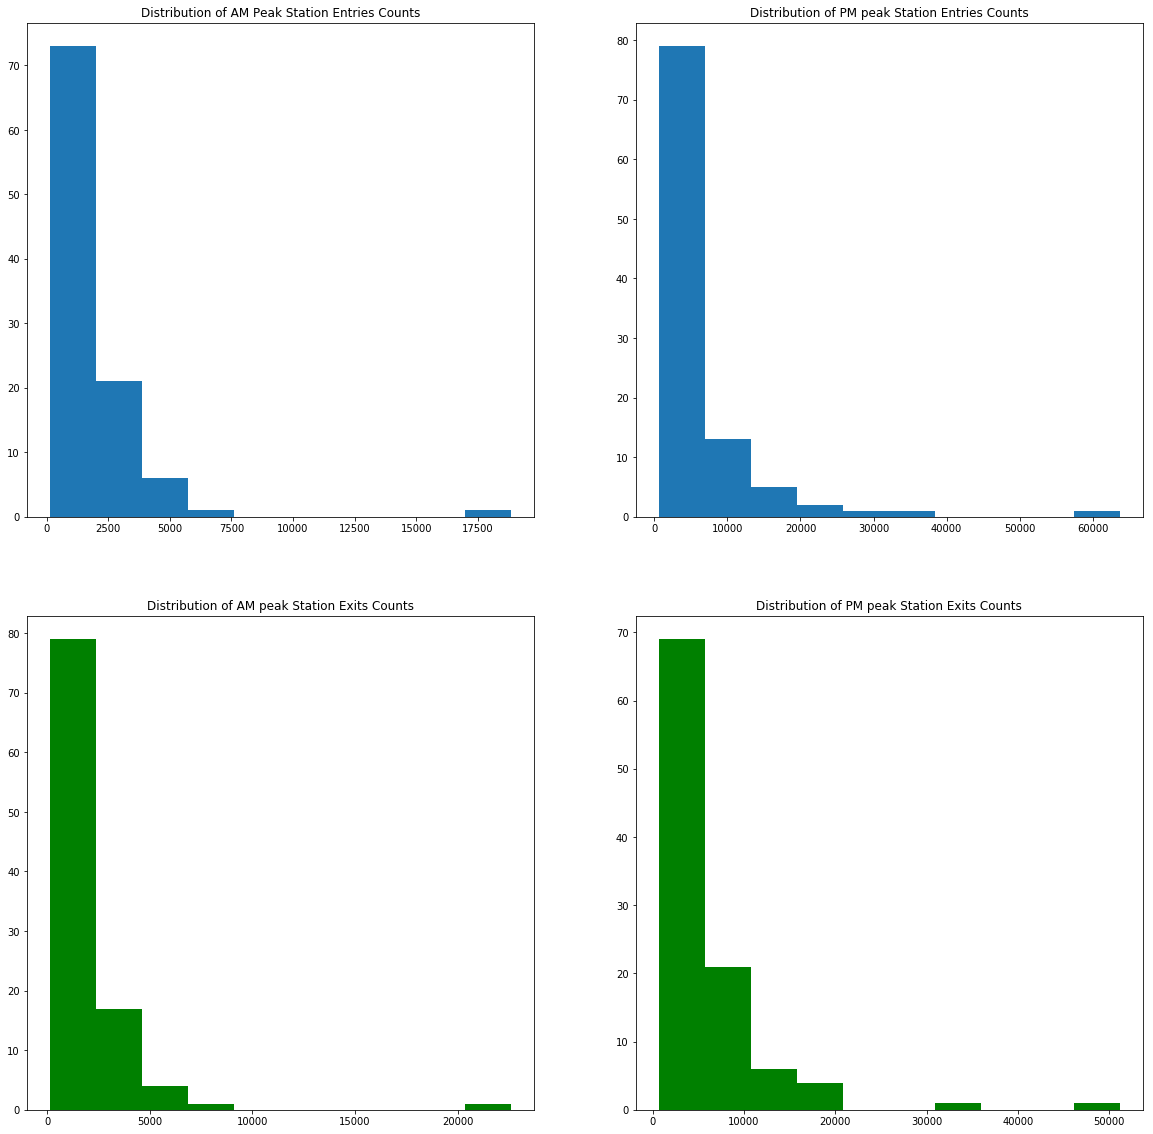

In [52]:
fig = plt.figure(figsize = (20,20))

ax = plt.subplot(2, 2, 1)
plt.hist(feb01AMPeak_geo_IN['Count'])
plt.title('Distribution of AM Peak Station Entries Counts')


ax1 = plt.subplot(2, 2, 2)
plt.hist(feb01PMPeak_geo_IN['Count'])
plt.title('Distribution of PM peak Station Entries Counts')

ax2 = plt.subplot(2, 2, 3)
plt.hist(feb01AMPeak_geo_OUT['Count'], color='green')
plt.title('Distribution of AM peak Station Exits Counts')

ax3 = plt.subplot(2, 2, 4)
plt.hist(feb01PMPeak_geo_OUT['Count'], color='green')
plt.title('Distribution of PM peak Station Exits Counts')

plt.show()

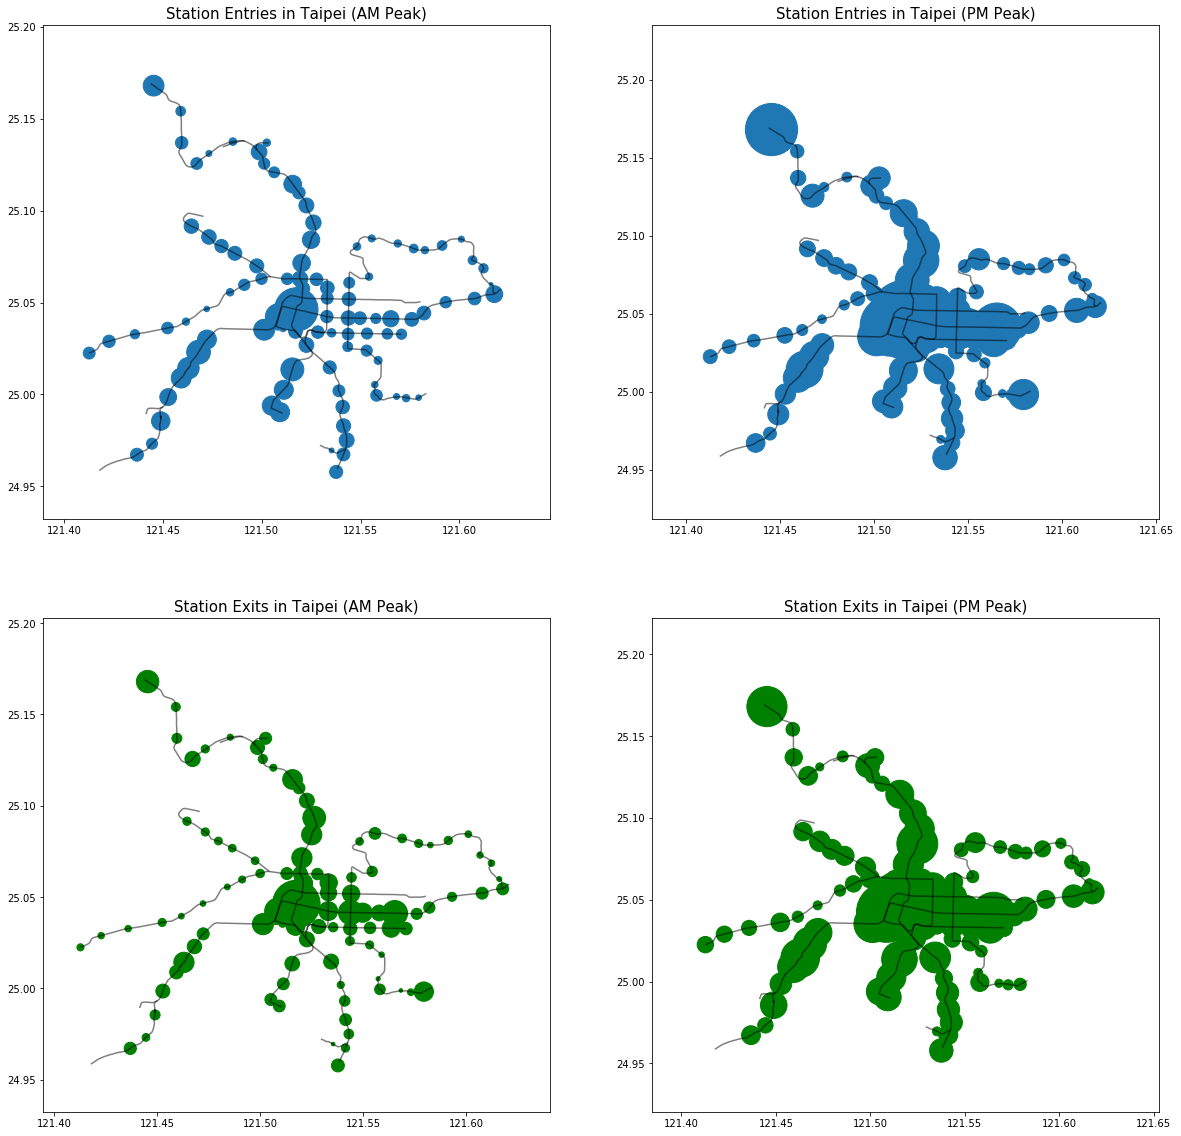

In [46]:
fig = plt.figure(figsize = (20,20))

ax = plt.subplot(2, 2, 1)
feb01AMPeak_geo_IN.plot(ax=ax, markersize=feb01AMPeak_geo_IN['Count']*0.1)
route['geometry'].plot(ax=ax, color='black', alpha=0.5)
plt.title('Station Entries in Taipei (AM Peak)', size=15)

ax1 = plt.subplot(2, 2, 2)
feb01PMPeak_geo_IN.plot(ax=ax1, markersize=feb01PMPeak_geo_IN['Count']*0.1)
route['geometry'].plot(ax=ax1, color='black', alpha=0.5)
plt.title('Station Entries in Taipei (PM Peak)', size=15)

ax2 = plt.subplot(2, 2, 3)
feb01AMPeak_geo_OUT.plot(ax=ax2, markersize=feb01AMPeak_geo_OUT['Count']*0.1, c='green')
route['geometry'].plot(ax=ax2, color='black', alpha=0.5)
plt.title('Station Exits in Taipei (AM Peak)', size=15)

ax3 = plt.subplot(2, 2, 4)
feb01PMPeak_geo_OUT.plot(ax=ax3, markersize=feb01PMPeak_geo_OUT['Count']*0.1, c='green')
route['geometry'].plot(ax=ax3, color='black', alpha=0.5)
plt.title('Station Exits in Taipei (PM Peak)', size=15)

plt.show()
plt.savefig('PeakTravePattern.PNG')

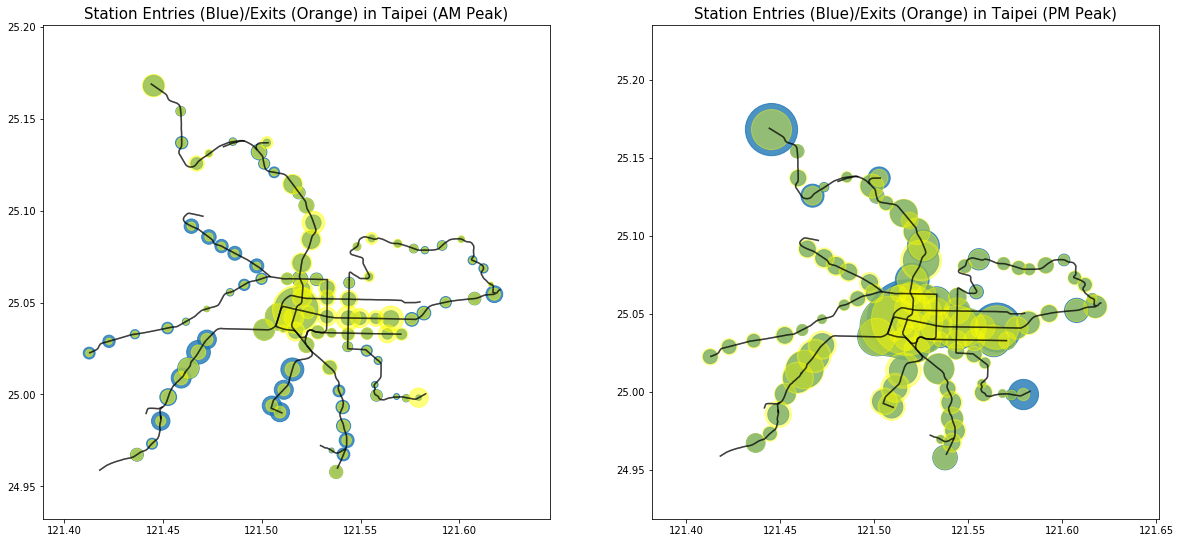

In [62]:
fig = plt.figure(figsize = (20,20))

ax = plt.subplot(2, 2, 1)
feb01AMPeak_geo_IN.plot(ax=ax, markersize=feb01AMPeak_geo_IN['Count']*0.1, alpha=0.8)
route['geometry'].plot(ax=ax, color='black', alpha=0.5)
plt.title('Station Entries (Blue)/Exits (Orange) in Taipei (AM Peak)', size=15)

ax1 = plt.subplot(2, 2, 2)
feb01PMPeak_geo_IN.plot(ax=ax1, markersize=feb01PMPeak_geo_IN['Count']*0.1, alpha=0.8)
route['geometry'].plot(ax=ax1, color='black', alpha=0.5)
plt.title('Station Entries (Blue)/Exits (Orange) in Taipei (PM Peak)', size=15)

ax2 = plt.subplot(2, 2, 1)
feb01AMPeak_geo_OUT.plot(ax=ax, markersize=feb01AMPeak_geo_OUT['Count']*0.1, c='yellow', alpha=0.5)
route['geometry'].plot(ax=ax2, color='black', alpha=0.5)

ax3 = plt.subplot(2, 2, 2)
feb01PMPeak_geo_OUT.plot(ax=ax1, markersize=feb01PMPeak_geo_OUT['Count']*0.1, c='yellow', alpha=0.4)
route['geometry'].plot(ax=ax1, color='black', alpha=0.5)

plt.show()


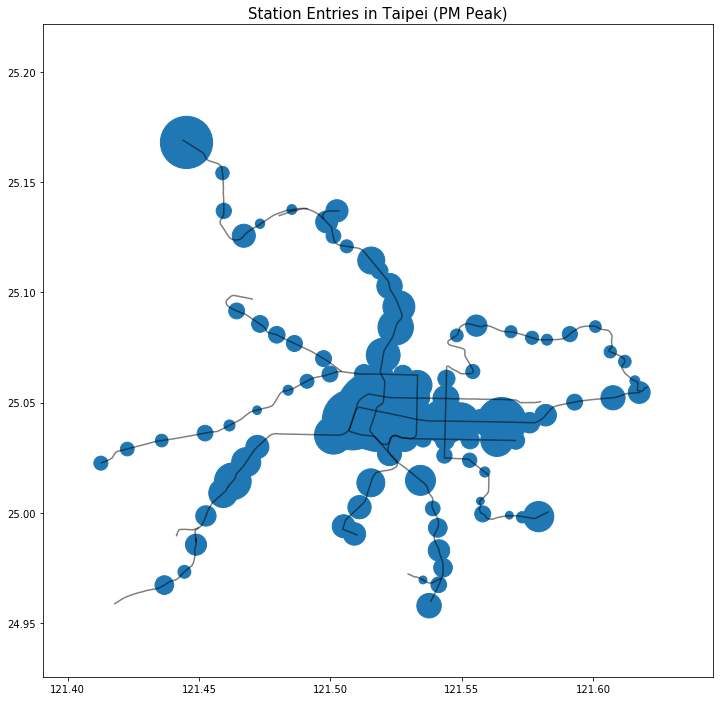

In [93]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax = feb01PMPeak_geo.plot(ax=ax, markersize=feb01PMPeak_geo['Count']*0.1)
ax = route['geometry'].plot(ax=ax, color='black', alpha=0.5)
plt.title('Station Entries in Taipei (PM Peak)', size=15)
plt.show()